In [1]:
import os
from dotenv import load_dotenv
from pathlib import Path

NOTEBOOK_PATH = Path().resolve()
dotenv_path = NOTEBOOK_PATH / "postgres.env"
load_dotenv(dotenv_path)

DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBUSER = os.environ.get("DBUSER")
DBNAME = os.environ.get("DBNAME")
DBPASS = os.environ.get("DBPASS")

In [2]:
from sqlalchemy import create_engine, URL

engine_url = URL.create(
    drivername="postgresql+psycopg2",
    username=DBUSER,
    password=DBPASS,
    host=DBHOST,
    port=DBPORT,
    database=DBNAME,
)

engine = create_engine(url=engine_url)

In [6]:
import pandas as pd
import geopandas

query = """
            SELECT 
                p.name,
                p.latitude,
                p.longitude,
                d.year, 
                d.month, 
                d.day, 
                r.amount
            FROM rainfall r
            JOIN places p
            ON p.place_id = r.place_id
            JOIN dates d
            on r.date_id = d.date_id
            ;
        """

df = pd.read_sql(query, engine)

# geo_df = geopandas.GeoDataFrame(
#     df,
#     geometry=geopandas.points_from_xy(df.longitude, df.latitude),
#     crs="EPSG:4326"
# )

ph_shp = geopandas.read_file(
    NOTEBOOK_PATH / 
    "raw_files" / 
    "Shapefile" / 
    "PH_Adm2_ProvDists.shp.zip"
)


In [20]:
grouped_df = df.groupby(by=["year", "month", "day", "name"]).mean()
idx = pd.IndexSlice
test_df = grouped_df.loc[idx["2009","1"],].groupby(by=["name"]).mean()
test_df

,latitude,longitude,amount
name,,,
"ALABAT, QUEZON",14.105694,122.017589,6.521918
"AMBULONG, BATANGAS",14.090081,121.055244,5.830411
"APARRI, CAGAYAN",18.359681,121.630433,5.764110
"BAGUIO CITY, BENGUET",16.404100,120.601447,16.814795
"BALER, AURORA (RADAR)",15.749367,121.632047,7.726575
"BASCO, BATANES",20.427731,121.970642,5.104658
"BORONGAN, EASTERN SAMAR",11.660908,125.443639,13.712329
"BUTUAN CITY, AGUSAN DEL NORTE",8.946992,125.482433,6.329315
"CABANATUAN, NUEVA ECIJA",15.471469,120.951914,7.322466


In [31]:
import numpy as np


minx, miny, maxx, maxy = ph_shp.total_bounds

grid_space = 0.2

grid_lon = np.arange(minx, maxx, grid_space)
grid_lat = np.arange(miny, maxy, grid_space)

all_lons = np.meshgrid(grid_lon, grid_lat)[0].ravel()
all_lats = np.meshgrid(grid_lon, grid_lat)[1].ravel()

ph_grid = pd.DataFrame()
ph_grid["longitude"] = all_lons
ph_grid["latitude"] = all_lats


ph_grid.head()

geo_ph_grid = geopandas.GeoDataFrame(
    ph_grid,
    geometry=geopandas.points_from_xy(ph_grid.longitude, ph_grid.latitude),
    crs="EPSG:4326"
)



In [38]:

intersection = geo_ph_grid.overlay(ph_shp, how="intersection")
# ax = ph_shp.plot(figsize=(20,20), color="gray")
# geo_ph_grid.plot(ax=ax)

intersection.head()

,longitude,latitude,psgc_code,name,corr_code,geo_level,city_class,inc_class,urb_rur,pop_2015,...,status,adm2_pcode,adm2_en,adm2_alt,adm1_pcode,adm0_pcode,shape_len,shape_area,shape_sqkm,geometry
0,119.477892,4.787294,1907000000,Tawi-Tawi,157000000.0,Prov,None,None,3rd,None,...,None,PH19070,Tawi-Tawi,None,PH19,PH,15.971439,0.094186,1154.581927,POINT (119.47789 4.78729)
1,120.077892,5.187294,1907000000,Tawi-Tawi,157000000.0,Prov,None,None,3rd,None,...,None,PH19070,Tawi-Tawi,None,PH19,PH,15.971439,0.094186,1154.581927,POINT (120.07789 5.18729)
2,120.277892,5.187294,1907000000,Tawi-Tawi,157000000.0,Prov,None,None,3rd,None,...,None,PH19070,Tawi-Tawi,None,PH19,PH,15.971439,0.094186,1154.581927,POINT (120.27789 5.18729)
3,125.277892,5.787294,1208000000,Sarangani,128000000.0,Prov,None,None,2nd,None,...,None,PH12080,Sarangani,None,PH12,PH,5.172361,0.302231,3699.922429,POINT (125.27789 5.78729)
4,125.477892,5.787294,1108600000,Davao Occidental,118600000.0,Prov,None,None,4th,None,...,None,PH11086,Davao Occidental,None,PH11,PH,4.375574,0.160157,1960.498134,POINT (125.47789 5.78729)


In [36]:
test_df.head()

,latitude,longitude,amount
name,,,
"ALABAT, QUEZON",14.105694,122.017589,6.521918
"AMBULONG, BATANGAS",14.090081,121.055244,5.830411
"APARRI, CAGAYAN",18.359681,121.630433,5.764110
"BAGUIO CITY, BENGUET",16.404100,120.601447,16.814795
"BALER, AURORA (RADAR)",15.749367,121.632047,7.726575


In [37]:
intersection[["long", "lat"]].head()

,long,lat
0,119.477892,4.787294
1,120.077892,5.187294
2,120.277892,5.187294
3,125.277892,5.787294
4,125.477892,5.787294


In [32]:
from sklearn.neighbors import KNeighborsRegressor

x = test_df[["longitude", "latitude"]]
y = test_df[["amount"]]

model = KNeighborsRegressor(algorithm="kd_tree", n_neighbors=8, weights="distance").fit(x,y)

In [62]:
prediction = model.predict(intersection[["longitude", "latitude"]])

intersection["amount"] = pd.Series(prediction[:, 0])

<Axes: >

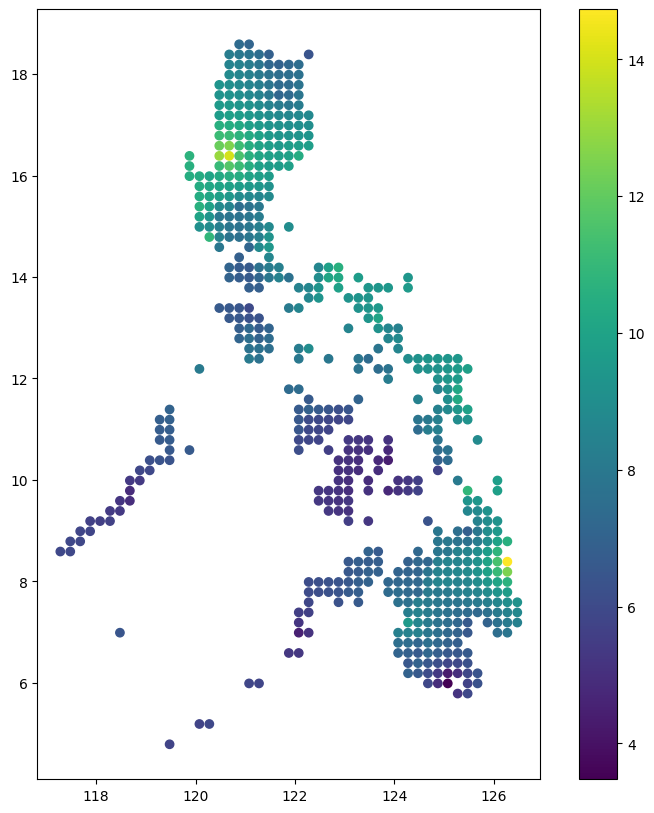

In [71]:
type(intersection[["longitude", "latitude", "amount"]])

geo_pred = geopandas.GeoDataFrame(
    intersection[["longitude", "latitude", "amount"]],
    geometry=geopandas.points_from_xy(intersection.longitude, intersection.latitude),
    crs="EPSG:4326"
)

geo_pred.plot(column="amount", figsize=(10,10), legend=True)
